In [28]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [29]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the characters dataset
<a class="anchor" id="load"></a>

In [30]:
DATA_PATH = './data'
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
ETHNICITIES_PATH =  os.path.join('ethnicities.csv')

In [31]:
a_cols = ['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date','character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']
df_chars=pd.read_csv(CHAR_PATH, sep='\t', names=a_cols)

# 2. Quick look at the data
<a class="anchor" id="quicklook"></a>

In [5]:
df_chars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   wikipedia_m_ID          450669 non-null  int64  
 1   freebase_m_ID           450669 non-null  object 
 2   m_release_date          440674 non-null  object 
 3   character_name          192794 non-null  object 
 4   actor_dob               344524 non-null  object 
 5   actor_gender            405060 non-null  object 
 6   actor_height            154824 non-null  float64
 7   actor_ethnicity         106058 non-null  object 
 8   actor_name              449441 non-null  object 
 9   actor_age               292556 non-null  float64
 10  freebase_character_map  450669 non-null  object 
 11  freebase_character_id   192804 non-null  object 
 12  freebase_actor_id       449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [6]:
df_chars.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
122012,1146934,/m/04bb7p,1997-12-03,NaN,1947-02-24,M,NaN,NaN,Mike Hodge,50.0,/m/0gcjq6d,NaN,/m/0d28jrv
225026,13931033,/m/03cnkmw,2007-09-28,Zé Tabacão,NaN,M,NaN,NaN,Otto Ferreira,NaN,/m/0jvv2yb,/m/0jvv2yf,/m/0jvv2yn
441414,10657592,/m/02qlg4b,2004,Bhai,1954-05-25,M,NaN,/m/04mvp8,Murali,49.0,/m/0h882_f,/m/0h882_h,/m/02qy3py
227637,2374400,/m/077dlr,1999,Turner,1948-12-21,M,1.89,/m/0x67,Samuel L. Jackson,50.0,/m/0cs30vm,/m/0gy9d2n,/m/0f5xn


# 3. Data preprocessing
<a class="anchor" id="preprocessing"></a>

#### Columns conversion

In [7]:
#Change problematic dates
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_chars['actor_dob'] = df_chars['actor_dob'].apply(lambda x: str(x) if len(str(x)) <=10 else str(x)[:10])
df_chars['actor_dob'] = pd.to_datetime(df_chars['actor_dob'], errors = 'coerce')

#### Actor age

In [8]:
# Number of characters whose actor has a negative age when appearing in the movie
nb_chars_negative_age = df_chars[df_chars['actor_age'] <= 0]['actor_age'].value_counts().sum()
print("There are {} characters whose actor has a negative age.".format(nb_chars_negative_age))

There are 433 characters whose actor has a negative age.


#### Actor name

In [9]:
# Number of characters whose actor is named 'NaN'
df_chars['actor_name'].value_counts(dropna=False)[:10]

NaN                   1228
Mel Blanc              791
Mithun Chakraborty     328
Oliver Hardy           299
Mohanlal               234
Moe Howard             225
Mammootty              225
Dharmendra Deol        219
Larry Fine             219
Amitabh Bachchan       206
Name: actor_name, dtype: int64

In [10]:
# Number of characters whose actor is named 'NaN'
nb_chars_nan = df_chars['actor_name'].value_counts(dropna=False)[np.nan]
print("There are {} characters whose actor name is nan.".format(nb_chars_nan))

There are 1228 characters whose actor name is nan.


#### Duplicated characters

In [11]:
# Number of duplicates
nb_char_duplicates = df_chars.duplicated().sum()
print("There are {} duplicated characters. So there is no duplicated row.".format(nb_char_duplicates))

There are 0 duplicated characters. So there is no duplicated row.


In [12]:
# Number of occurrences with same subset of columns as described below
nb_char_duplicates_sub = df_chars.duplicated(subset=['wikipedia_m_ID', 'character_name', 'actor_name', 'm_release_date']).sum()
print("There are {} characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.".format(nb_char_duplicates_sub))

There are 1086 characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.


#### Casting date of birth

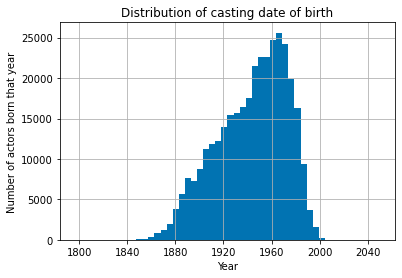

There are 59 actors born before 1850.
There are 1 actors born after 2013.


In [13]:
#Looking at date of birth
plt.title('Distribution of casting date of birth')
plt.xlabel('Year')
plt.ylabel('Number of actors born that year')
plt.hist(df_chars['actor_dob'], bins=50, color=BLUE)
plt.grid()
plt.show()
date_born_min = df_chars.loc[df_chars['actor_dob'].dt.year<1850]['wikipedia_m_ID'].count()
date_born_max = df_chars.loc[df_chars['actor_dob'].dt.year>2013]['wikipedia_m_ID'].count()
print("There are {} actors born before 1850.\nThere are {} actors born after 2013.".format(date_born_min, date_born_max))

In [14]:
#The actors born before 1850 have all nan as age.
df_chars.loc[df_chars['actor_dob'].dt.year<1850]['actor_age'].unique()

array([nan])

In [15]:
#The actor born after 2013 has a negative age. He'll be dropped in the next cell
df_chars.loc[df_chars['actor_dob'].dt.year>2013]['actor_age'].unique()

array([-37.])

In [16]:
date_movie_first_release = df_chars['m_release_date'].min()
print("The first movie is released in {}.".format(date_movie_first_release.year))

The first movie is released in 1888.


The actor database contains following errors:
- **Actors with negative age**: is (at least in some cases (wikipedia_movie_id: 15007384)) due to actors having the same last name, which probably led to some scraping missmatch, e.g. a movie attributed to a son when it was in fact his father acting. We are going to drop those since it is clearly mistaken.
- **Actors with name 'Nan'**: there is no way for us to qualitatively use this data, so we will drop them.
- **Actors duplicates**: some duplicates were identified, we will safely remove them.
- **Actors with old date of birth**: there are some actors with really old date of birth (59 before 1850). It was decided to safely remove their characters.

#### Cleaning

In [17]:
def cast_age(x):
    try:
        value = int(x)
    except:
        value = np.nan
    return value

In [18]:
df_chars['actor_age'] = df_chars['actor_age'].apply(lambda x: cast_age(x))
df_chars['actor_age'] = df_chars.apply(lambda row: row['m_release_date'].year - row['actor_dob'].year if (row['actor_age']==np.nan and row['actor_dob']!=np.nan and row['m_release_date']!=np.nan) else row['actor_age'], axis=1)
df_chars = df_chars.loc[(df_chars['actor_age'] >=0) | (df_chars['actor_age'].isna())]

df_chars = df_chars.loc[(df_chars['actor_dob'].dt.year >=1850) | (df_chars['actor_dob'].isna())]
df_chars.dropna(subset='actor_name', inplace=True)
df_chars.drop_duplicates(subset=["wikipedia_m_ID", "character_name", "actor_name", "m_release_date"], keep=False, inplace=True)

#### Cleaned CSV

In [21]:
OUTPUT_FILE = 'characters_cleaned.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE)
df_chars.to_csv(OUTPUT_PATH, sep="\t")